In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!mkdir -p coco_data
!unzip -q train2017.zip -d coco_data/
!unzip -q annotations_trainval2017.zip -d coco_data/
!rm train2017.zip annotations_trainval2017.zip

In [ ]:
%pip install pycocotools torch torchvision transformers

In [13]:
import os
print(os.listdir("coco_data"))
print(os.listdir("coco_data/annotations"))

['train2017', 'annotations']
['captions_train2017.json', 'person_keypoints_train2017.json', 'person_keypoints_val2017.json', 'instances_train2017.json', 'captions_val2017.json', 'instances_val2017.json']


loading annotations into memory...


Done (t=20.05s)
creating index...
index created!


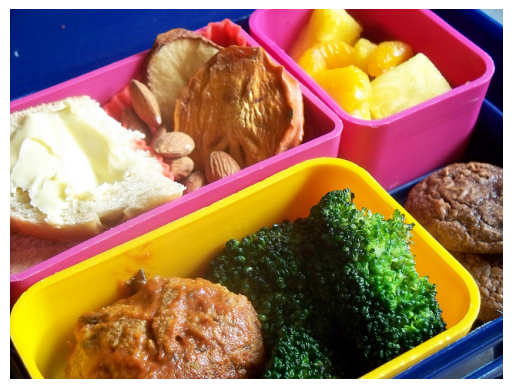

Captions for this image:
1. Closeup of bins of food that include broccoli and bread.
2. A meal is presented in brightly colored plastic trays.
3. there are containers filled with different kinds of foods
4. Colorful dishes holding meat, vegetables, fruit, and bread.
5. A bunch of trays that have different food.


In [15]:
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import json
import random

coco_dataset = datasets.CocoDetection(
    root="coco_data/train2017",
    annFile="coco_data/annotations/instances_train2017.json",
    transform=transforms.ToTensor()
)
with open("coco_data/annotations/captions_train2017.json", "r") as f:
    captions_data = json.load(f)
    img, target = coco_dataset[0]

image_id = target[0]['image_id']
captions = [ann["caption"] for ann in captions_data["annotations"] if ann["image_id"] == image_id]
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()
print("Captions for this image:")
for i, caption in enumerate(captions):
    print(f"{i+1}. {caption}")

In [16]:
import json
import os
import torch
import random
from torch.utils.data import Dataset
from PIL import Image

class COCOCaption(Dataset):
    def __init__(self, image_dir, caption_file, processor, max_samples=10000):
        with open(caption_file, "r") as f:
            self.coco_data = json.load(f)

        self.image_dir = image_dir
        self.processor = processor
        all_img_ids = list(set(ann["image_id"] for ann in self.coco_data["annotations"]))
        random.seed(42)
        self.img_ids = random.sample(all_img_ids, min(max_samples, len(all_img_ids)))
        self.img_captions = {ann["image_id"]: ann["caption"] for ann in self.coco_data["annotations"] if ann["image_id"] in self.img_ids}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_filename = os.path.join(self.image_dir, f"{img_id:012d}.jpg")

        try:
            image = Image.open(img_filename).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: {img_filename} not found.")
            return None

        caption = self.img_captions.get(img_id, "")

        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        if "attention_mask" not in encoding:
            encoding["attention_mask"] = torch.ones_like(encoding["input_ids"])
        
        return encoding

In [17]:
from transformers import AutoProcessor, BlipForConditionalGeneration
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [19]:
from torch.utils.data import DataLoader

dataset = COCOCaption(
    image_dir="coco_data/train2017",
    caption_file="coco_data/annotations/captions_train2017.json",
    processor=processor,
)

In [20]:
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=5)

In [9]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(3):
    total_loss = 0
    for batch in train_dataloader:
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch}: Loss = {total_loss / len(train_dataloader)}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 0: Loss = 0.2592335745478049
Epoch 1: Loss = 0.04300563731975853
Epoch 2: Loss = 0.034119765921495855


In [ ]:
import torch
torch.save(model.state_dict(), "model.pth")
print("Model saved successfully!")

In [ ]:
model.load_state_dict(torch.load("model.pth"))
model.to(device)
model.eval()
print("Model loaded successfully!")

Using device: cuda


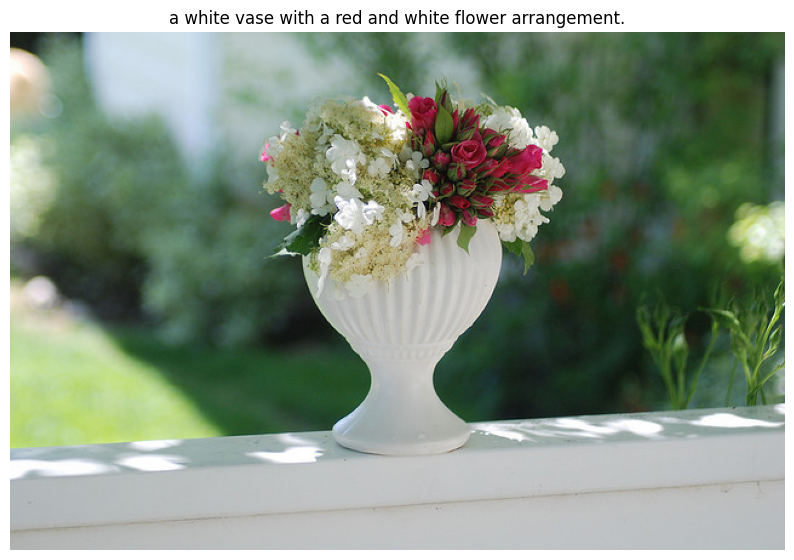

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

def generate_caption(image_path, processor, model, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    encoding = processor(images=image, return_tensors="pt").to(device)
    pixel_values = encoding["pixel_values"]

    with torch.no_grad():
        outputs = model.generate(pixel_values=pixel_values, max_length=50)
    caption = processor.decode(outputs[0], skip_special_tokens=True)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)
    plt.show()

    return caption

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

custom_weights = torch.load("model.pth", map_location=device)
model.load_state_dict(custom_weights)

model = model.to(device)

sample_image_path = "coco_data/train2017/000000000030.jpg"
try:
    caption = generate_caption(sample_image_path, processor, model, device)
except FileNotFoundError:
    print(f"Error: Image file not found at {sample_image_path}")
    print("Please check the path to your image file and try again.")

In [ ]:
%pip install nltk

In [32]:
import torch
import numpy as np
from PIL import Image
import json
import os
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import corpus_bleu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

custom_weights = torch.load("model.pth", map_location=device)
model.load_state_dict(custom_weights)
model = model.to(device)
model.eval()

def evaluate_on_coco(model, processor, annotation_file, image_dir, num_samples=100):
    print(f"Looking for images in: {image_dir}")
    available_images = set(os.listdir(image_dir)) if os.path.exists(image_dir) else set()
    
    if not available_images:
        print(f"WARNING: No images found in {image_dir}. Please check the path.")
        return None
    
    print(f"Found {len(available_images)} images")
    
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    
    image_dict = {}
    for img in data['images']:
        image_dict[img['id']] = img['file_name']
    
    references = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in references:
            references[img_id] = []
        references[img_id].append(ann['caption'])
    
    valid_image_ids = []
    for img_id, filename in image_dict.items():
        if filename in available_images and img_id in references:
            valid_image_ids.append(img_id)
    
    if not valid_image_ids:
        print("No matching images found between annotations and available files.")
        return None
    
    print(f"Found {len(valid_image_ids)} valid images with annotations")
    
    if num_samples and num_samples < len(valid_image_ids):
        valid_image_ids = valid_image_ids[:num_samples]
    
    candidate_captions = []
    reference_captions = []
    processed_images = []
    
    for img_id in tqdm(valid_image_ids):
        image_path = os.path.join(image_dir, image_dict[img_id])
        try:
            image = Image.open(image_path).convert("RGB")
            encoding = processor(images=image, return_tensors="pt").to(device)
            
            with torch.no_grad():
                outputs = model.generate(pixel_values=encoding["pixel_values"], max_length=50)
            
            caption = processor.decode(outputs[0], skip_special_tokens=True)
            candidate_captions.append(caption.split())
            
            refs = [ref.split() for ref in references[img_id]]
            reference_captions.append(refs)
            processed_images.append(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    if len(candidate_captions) == 0:
        print("No images were successfully processed.")
        return None
    
    print(f"Successfully processed {len(candidate_captions)} images")
    
    bleu1 = corpus_bleu(reference_captions, candidate_captions, weights=(1, 0, 0, 0))
    
    results = {
        'BLEU-1': bleu1 * 100,
        'Processed Images': len(candidate_captions)
    }
    
    return results, processed_images, candidate_captions, reference_captions

annotation_file = "coco_data/annotations/captions_train2017.json"
image_dir = "coco_data/train2017"

results, processed_images, generated_captions, reference_captions = evaluate_on_coco(model, processor, annotation_file, image_dir, num_samples=50)

if results:
    print("\nEvaluation Results:")
    for metric, score in results.items():
        if isinstance(score, (int, float)):
            print(f"{metric}: {score:.2f}")
        else:
            print(f"{metric}: {score}")
    
    print("\nSample Predictions (first 5):")
    for i in range(min(5, len(processed_images))):
        print(f"\nImage: {os.path.basename(processed_images[i])}")
        print(f"Generated: {' '.join(generated_captions[i])}")
        print(f"References:")
        for j, ref in enumerate(reference_captions[i]):
            print(f"  Ref {j+1}: {' '.join(ref)}")

Using device: cuda


Looking for images in: coco_data/train2017
Found 118287 images
Found 118287 valid images with annotations


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


Successfully processed 50 images

Evaluation Results:
BLEU-1: 61.76
Processed Images: 50.00

Sample Predictions (first 5):

Image: 000000391895.jpg
Generated: a man is standing on a muddy road with a backpack.
References:
  Ref 1: A man with a red helmet on a small moped on a dirt road.
  Ref 2: Man riding a motor bike on a dirt road on the countryside.
  Ref 3: A man riding on the back of a motorcycle.
  Ref 4: A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains.
  Ref 5: A man in a red shirt and a red hat is on a motorcycle on a hill side.

Image: 000000522418.jpg
Generated: a woman is cutting a book with a knife.
References:
  Ref 1: A woman wearing a net on her head cutting a cake.
  Ref 2: A woman cutting a large white sheet cake.
  Ref 3: A woman wearing a hair net cutting a large sheet cake.
  Ref 4: there is a woman that is cutting a white cake
  Ref 5: A woman marking a cake with t